18.338 % of dataset dropped when truncating gas used equal to lower limit of 21000


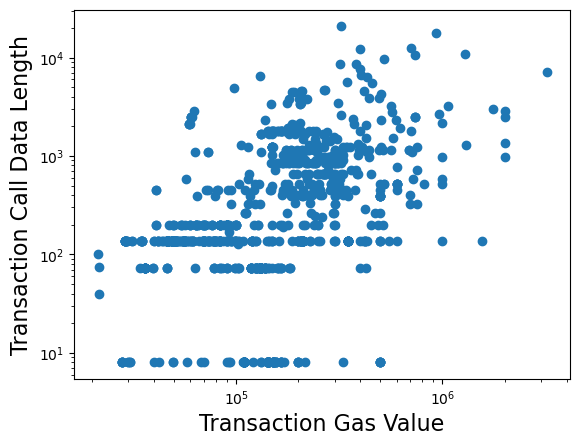

In [39]:
#####  This block cleans the data and plots call data vs gas  #####

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
from sklearn.utils import shuffle
import random
from sklearn.linear_model import LinearRegression

data=pd.read_csv('TxF22.csv')
TxGas=list(data['gas']) #change to gas_used for old data from last year
TxCallData=list(data['input'])
TxCallData=[len(x[2:]) for x in TxCallData] #length of calldata after '0x' string for each entry

#upperLimit=500000 #drop extreme high Tx values
lowerLimitGas=21000 #drop extreme low Tx values
#print(round(100*(1-np.size([x for x in TxGas if x <= upperLimit])/np.size(TxGas)),3), '% of dataset dropped when truncating gas used over upper limit of',upperLimit )
proportionGasLowerLimit=(np.size([x for x in TxGas if x == lowerLimitGas])/np.size(TxGas))
print(round(100*proportionGasLowerLimit,3), '% of dataset dropped when truncating gas used equal to lower limit of',lowerLimitGas )
#lowerLimitCallData=0
#proportionCallDataLowerLimit=np.size([x for x in TxCallData if x == lowerLimitCallData])/np.size(TxCallData)
#print(round(100*proportionCallDataLowerLimit,3), '% of dataset dropped when truncating call data used equal to',lowerLimitCallData )

#Now randomly sample x and 1-x % of Tx to create test and training sets
np.random.seed(10)
(TxGas,TxCallData) = shuffle(TxGas,TxCallData) 
#df=pd.DataFrame({'TxGas':TxGas,'TxCallData':TxCallData})
#dfDropZeroCallData = df[df.TxCallData != 0]

fig, ax = plt.subplots()
#ax.scatter(dfDropZeroCallData['TxGas'],dfDropZeroCallData['TxCallData'])
ax.scatter(TxGas,TxCallData)
#model = LinearRegression().fit(np.array(list(dfDropZeroCallData['TxGas'])).reshape((-1, 1)),list(dfDropZeroCallData['TxCallData']))
#ax.annotate('R-sq =' + str(round(model.score( np.array(list(dfDropZeroCallData['TxGas'])),list(dfDropZeroCallData['TxCallData'])   ),3)) ,xycoords='axes fraction',ha='right',va="center",fontsize=10)
plt.xlabel('Transaction Gas Value', fontsize=16)
plt.ylabel('Transaction Call Data Length', fontsize=16)
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()



#TxGas=[x for x in TxGas if x <= upperLimit] #drop all over limit
TxGas=[x for x in TxGas if x != lowerLimitGas] #drop all equal to lower limit

#TxCallData=[x for x in TxCallData if x != 0] #drop all call data equal to 0

testSize=20 # % of Txs that will make up test set
TxGasTest=TxGas[0:round(len(TxGas)*testSize/100)]
TxGasTrain=TxGas[round(len(TxGas)*testSize/100):]

TxCallDataTest=TxCallData[0:round(len(TxCallData)*testSize/100)]
TxCallDataTrain=TxCallData[round(len(TxCallData)*testSize/100):]

#display(TxCallData)



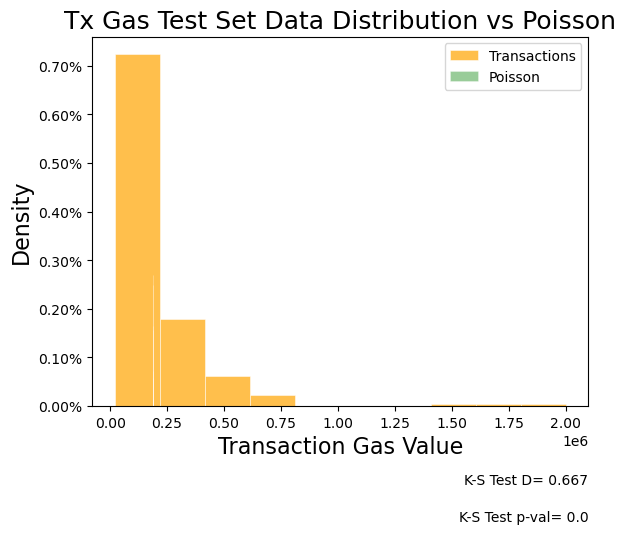

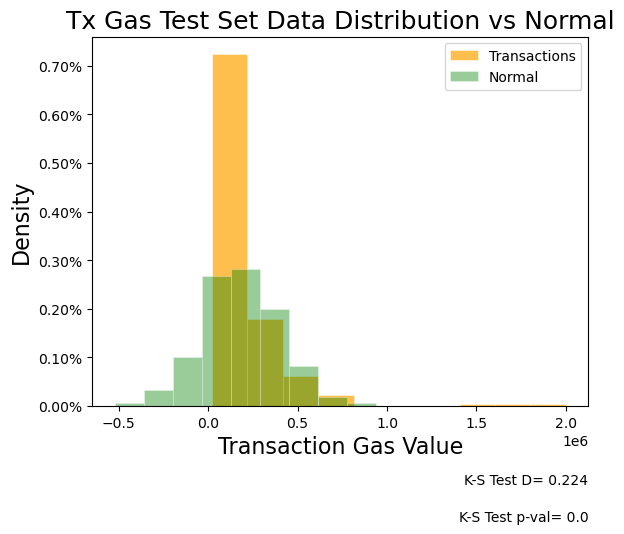

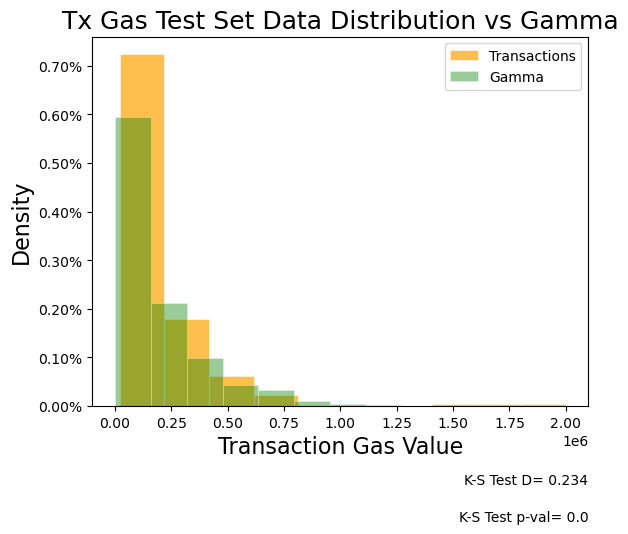

In [3]:
#####  This block fits gas to poisson/normal/gamma, runs K-S tests, and plots histograms  #####



#Tx=poisson(10,200000) #np.array([0,1,1.4,2,4,1,2,4,1,3,6,2,3,6,1,5])


numRVs=np.size(TxGasTrain)
poissGas=stats.poisson.rvs(np.mean(TxGasTrain),size=numRVs) #generate poisson points using estimated lambda from Tx data
norGas=np.random.normal(np.mean(TxGasTrain),np.var(TxGasTrain)**0.5,numRVs)  #generate poisson points using estimated lambda from Tx data

#MoM estimation of gamma distr:
aGas=(np.mean(TxGasTrain))**2/np.var(TxGasTrain)
betaGas=(np.mean(TxGasTrain))/np.var(TxGasTrain)
gamGas=stats.gamma.rvs(aGas, scale=1/betaGas,size=numRVs)




fig, ax = plt.subplots()
binNumTxGas=1000
binNumDistr=100
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.hist(TxGasTest,alpha=0.7,label='Transactions', linewidth=0.5, color='orange', edgecolor="white",weights=np.ones(len(TxGasTest)) / len(TxGasTest) )
plt.xlabel('Transaction Gas Value', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.title('Tx Gas Test Set Data Distribution vs Poisson', fontsize=18)
#ax.set_xscale('log')
ax.hist(poissGas,label='Poisson', alpha=0.4, linewidth=0.5, color='g', edgecolor="white",weights=np.ones(len(poissGas)) / len(poissGas) )
ax.annotate('K-S Test D= ' + str(round(stats.kstest(TxGasTest, poissGas)[0],3)),xy = (1, -0.2),xycoords='axes fraction',ha='right',va="center",fontsize=10)
ax.annotate('K-S Test p-val= ' + str(round(stats.kstest(TxGasTest, poissGas)[1],5)),xy = (1, -0.3),xycoords='axes fraction',ha='right',va="center",fontsize=10)
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.hist(TxGasTest,alpha=0.7, label='Transactions', linewidth=0.5, color='orange', edgecolor="white",weights=np.ones(len(TxGasTest)) / len(TxGasTest) )
plt.xlabel('Transaction Gas Value', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.title('Tx Gas Test Set Data Distribution vs Normal', fontsize=18)
#ax.set_xscale('log')
ax.hist(norGas,label='Normal', alpha=0.4, linewidth=0.5, color='g', edgecolor="white",weights=np.ones(len(norGas)) / len(norGas) )
ax.annotate('K-S Test D= ' + str(round(stats.kstest(TxGasTest, norGas)[0],3)),xy = (1, -0.2),xycoords='axes fraction',ha='right',va="center",fontsize=10)
ax.annotate('K-S Test p-val= ' + str(round(stats.kstest(TxGasTest, norGas)[1],5)),xy = (1, -0.3),xycoords='axes fraction',ha='right',va="center",fontsize=10)
#fig.tight_layout()
ax.legend()
plt.show()


fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.hist(TxGasTest,alpha=0.7, label='Transactions', linewidth=0.5, color='orange', edgecolor="white",weights=np.ones(len(TxGasTest)) / len(TxGasTest) )
plt.xlabel('Transaction Gas Value', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.title('Tx Gas Test Set Data Distribution vs Gamma', fontsize=18)
#ax.set_xscale('log')
ax.hist(gamGas,label='Gamma', alpha=0.4, linewidth=0.5, color='g', edgecolor="white",weights=np.ones(len(gamGas)) / len(gamGas) )
ax.annotate('K-S Test D= ' + str(round(stats.kstest(TxGasTest, gamGas)[0],3)),xy = (1, -0.2),xycoords='axes fraction',ha='right',va="center",fontsize=10)
ax.annotate('K-S Test p-val= ' + str(round(stats.kstest(TxGasTest, gamGas)[1],5)),xy = (1, -0.3),xycoords='axes fraction',ha='right',va="center",fontsize=10)
ax.legend()
plt.show()



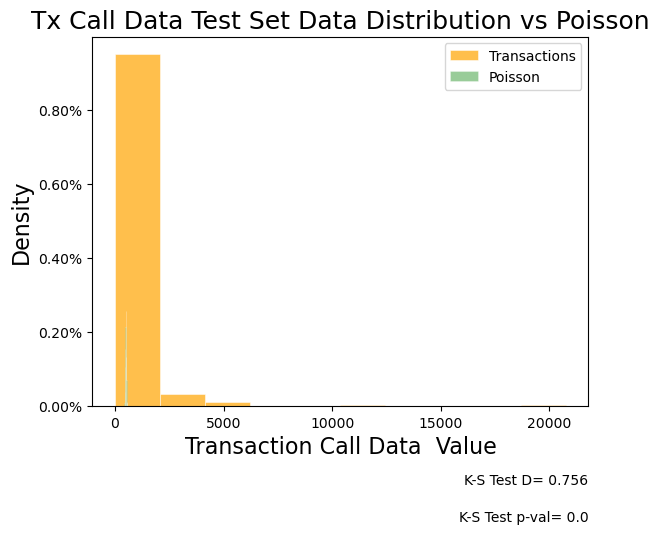

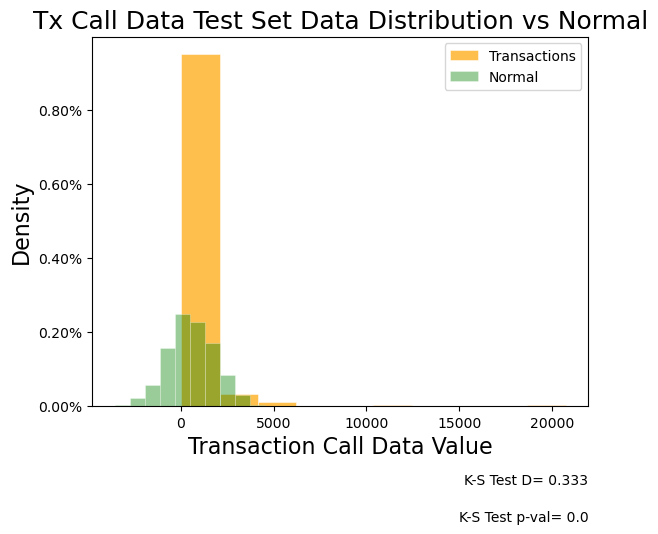

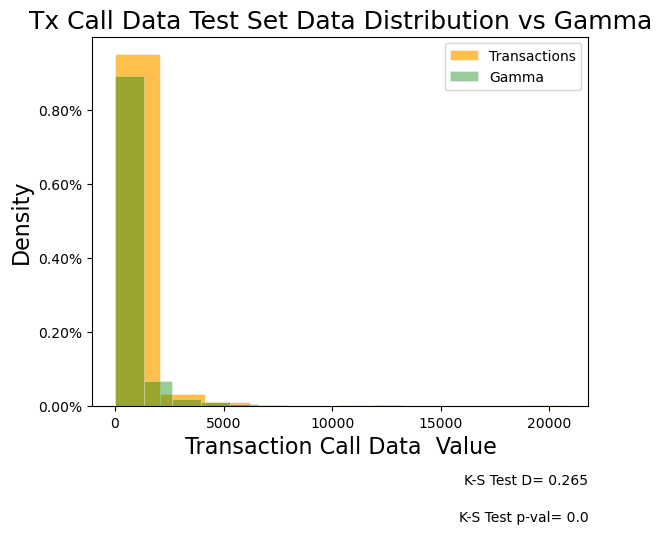

In [4]:
#####  This block fits call data to poisson/normal/gamma, runs K-S tests, and plots histograms  #####

numRVs=np.size(TxCallDataTrain)
poissCallData=stats.poisson.rvs(np.mean(TxCallDataTrain),size=numRVs) #generate poisson points using estimated lambda from Tx data
norCallData=np.random.normal(np.mean(TxCallDataTrain),np.var(TxCallDataTrain)**0.5,numRVs)  #generate poisson points using estimated lambda from Tx data

#MoM estimation of gamma distr:
aCallData=(np.mean(TxCallDataTrain))**2/np.var(TxCallDataTrain)
betaCallData=(np.mean(TxCallDataTrain))/np.var(TxCallDataTrain)
gamCallData=stats.gamma.rvs(aCallData, scale=1/betaCallData,size=numRVs)




fig, ax = plt.subplots()
binNumTxCallData=1000
binNumDistr=100
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.hist(TxCallDataTest,alpha=0.7,label='Transactions', linewidth=0.5, color='orange', edgecolor="white",weights=np.ones(len(TxCallDataTest)) / len(TxCallDataTest) )
plt.xlabel('Transaction Call Data  Value', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.title('Tx Call Data Test Set Data Distribution vs Poisson', fontsize=18)
#ax.set_xscale('log')
ax.hist(poissCallData,label='Poisson', alpha=0.4, linewidth=0.5, color='g', edgecolor="white",weights=np.ones(len(poissCallData)) / len(poissCallData) )
ax.annotate('K-S Test D= ' + str(round(stats.kstest(TxCallDataTest, poissCallData)[0],3)),xy = (1, -0.2),xycoords='axes fraction',ha='right',va="center",fontsize=10)
ax.annotate('K-S Test p-val= ' + str(round(stats.kstest(TxCallDataTest, poissCallData)[1],5)),xy = (1, -0.3),xycoords='axes fraction',ha='right',va="center",fontsize=10)
ax.legend()
plt.show()


fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.hist(TxCallDataTest,alpha=0.7, label='Transactions', linewidth=0.5, color='orange', edgecolor="white",weights=np.ones(len(TxCallDataTest)) / len(TxCallDataTest) )
plt.xlabel('Transaction Call Data Value', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.title('Tx Call Data Test Set Data Distribution vs Normal', fontsize=18)
#ax.set_xscale('log')
ax.hist(norCallData,label='Normal', alpha=0.4, linewidth=0.5, color='g', edgecolor="white",weights=np.ones(len(norCallData)) / len(norCallData) )
ax.annotate('K-S Test D= ' + str(round(stats.kstest(TxCallDataTest, norCallData)[0],3)),xy = (1, -0.2),xycoords='axes fraction',ha='right',va="center",fontsize=10)
ax.annotate('K-S Test p-val= ' + str(round(stats.kstest(TxCallDataTest, norCallData)[1],5)),xy = (1, -0.3),xycoords='axes fraction',ha='right',va="center",fontsize=10)
#fig.tight_layout()
ax.legend()
plt.show()


fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.hist(TxCallDataTest,alpha=0.7, label='Transactions', linewidth=0.5, color='orange', edgecolor="white",weights=np.ones(len(TxCallDataTest)) / len(TxCallDataTest) )
plt.xlabel('Transaction Call Data  Value', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.title('Tx Call Data Test Set Data Distribution vs Gamma', fontsize=18)
#ax.set_xscale('log')
ax.hist(gamCallData,label='Gamma', alpha=0.4, linewidth=0.5, color='g', edgecolor="white",weights=np.ones(len(gamCallData)) / len(gamCallData) )
ax.annotate('K-S Test D= ' + str(round(stats.kstest(TxCallDataTest, gamCallData)[0],3)),xy = (1, -0.2),xycoords='axes fraction',ha='right',va="center",fontsize=10)
ax.annotate('K-S Test p-val= ' + str(round(stats.kstest(TxCallDataTest, gamCallData)[1],5)),xy = (1, -0.3),xycoords='axes fraction',ha='right',va="center",fontsize=10)
ax.legend()
plt.show()



In [17]:
#####  This block generates gas and call data from separate gamma distributions  #####


#Now generate from Tx-gamma:
lenGenerated=10
TxGasGenerated=[]
TxCallDataGenerated=[]
for i in range(lenGenerated):
    TxCallDataGenerated.append(float(stats.gamma.rvs(aCallData, scale=1/betaCallData,size=1))) #must change to break into if statement below to generate diff calldata distr when gas=21k           
    ran=random.uniform(0, 1)
    #ran2=random.uniform(0,1) #dont want to make mixture model for call data with 0s
    if ran<proportionGasLowerLimit:
        TxGasGenerated.append(lowerLimitGas)
    else: 
        TxGasGenerated.append(float(stats.gamma.rvs(aGas, scale=1/betaGas,size=1)))
    #if ran2<proportionCallDataLowerLimit:
    #    TxCallDataGenerated.append(lowerLimitCallData)
    #else: 
    #TxGasGenerated.append(float(stats.gamma.rvs(aGas, scale=1/betaGas,size=1)))
    
print(TxGasGenerated)
print(TxCallDataGenerated)




[296984.5003254002, 1067444.6363157516, 72170.07223137206, 882567.2473662014, 21000, 359820.84565992455, 62294.50919758174, 146065.27922287188, 144201.9722400043, 19599.234194575733]
[61.72003749751454, 0.06089851817436932, 7.616277945920654e-08, 215.52202385656614, 0.14203900116887444, 191.38201940196856, 169.43744632733006, 342.44657242490354, 36.91732146869682, 9.443936060679836e-07]


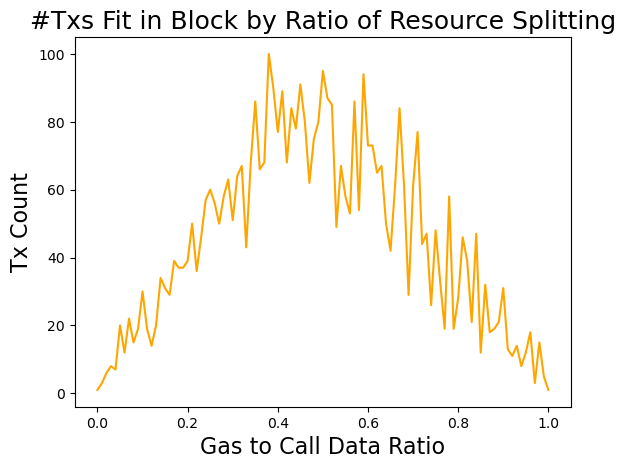

In [54]:
#####  This block generates gas and call data from separate gamma distributions  but now   #####

TxCount=[]
rangeGasRatio=np.linspace(0,1,101)
for i in rangeGasRatio:
    gasMEIPRatio=i #run simulation from 0 to 1 to optimize # Txs per block? or some other metric?
    callDataMEIPRatio=1-gasMEIPRatio
    currentGasLimit=30e6
    mEIPGasLimit=currentGasLimit*gasMEIPRatio #estimate the use of gas to be 2/3 of what calldata will be. How to improve this estimate?
    currentAvgTxPerBlock=round(currentGasLimit/np.mean(TxGasTrain)) #how many Tx we can fit into 30mil gas block
    mEIPCallDataLimit=round(callDataMEIPRatio*currentAvgTxPerBlock*np.mean(TxCallDataTrain)) #how much call data we can fit into block scaled by ratio of current CD to gas 

    TxGasGenerated=[]
    TxCallDataGenerated=[]
    while np.sum(TxGasGenerated)<=mEIPGasLimit and np.sum(TxCallDataGenerated)<=mEIPCallDataLimit:
        TxCallDataGenerated.append(float(stats.gamma.rvs(aCallData, scale=1/betaCallData,size=1)))
        ran=random.uniform(0, 1)
        #ran2=random.uniform(0,1) #dont want to make mixture model for call data with 0s
        if ran<proportionGasLowerLimit:
            TxGasGenerated.append(lowerLimitGas)
        else: 
            TxGasGenerated.append(float(stats.gamma.rvs(aGas, scale=1/betaGas,size=1)))
        #if ran2<proportionCallDataLowerLimit:
        #    TxCallDataGenerated.append(lowerLimitCallData)
        #else: 
        #TxGasGenerated.append(float(stats.gamma.rvs(aGas, scale=1/betaGas,size=1)))
    TxCount.append(len(TxGasGenerated))


fig, ax = plt.subplots()
ax.plot(rangeGasRatio,TxCount, color='orange')
plt.xlabel('Gas to Call Data Ratio', fontsize=16)
plt.ylabel('Tx Count', fontsize=16)
plt.title('#Txs Fit in Block by Ratio of Resource Splitting', fontsize=18)
plt.show()




In [47]:

#NEXT STEPS: 
#partition 21000 Txs and refit, avoid overfitting with gamma - test/training sets 
        #completed in block 1
#pick best rn bronze standard gamma is good enough now and hten some small work on gamma gamma - sample beta from diff users.
    #put whole story into the hackmd- with the 21000 then without then show how bad poisson and normal are and 
    #then show charts of how good the gmama does
    #include neagtive results too 
        #completed


#barnabe- in the case we aplit gas, we mY and Z are hard to explain but they are probably very correlated. 
#might not need x and y to = z
#longer term:        ppl using rollups are ok with waiting, execution is to go fast
#meip only reduced congestion if strong anticorrelation betwene 2 resources




#joint distribution. actually we do see like 5 clusters. what are their significance? diff call data lengths. am i accidentally using gas limit? not gas used?


######Similar to the high proportion of gas used falling at the lower limit of 21000, we see 23.0% of call data strings with a length of zero. Omitting these,  are we able to improve upon our models.
        #completed - omitting 0 calldata =worse
    
# dont draw from 2 distributions of callData/gas. draw from joint. how to model joint? copula? Cant assume marginals independent
#given 21k gas, genereate CD, rest independence


